In [40]:
import sys
import os
import  argparse
import datetime
import numpy as np
import pandas as pd
import h5py
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

import warnings
warnings.simplefilter("ignore")

from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
# get colormap
ncolors = 256
color_array = plt.get_cmap('jet')(range(ncolors))
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='jet_alpha',colors=color_array)
# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)
plnbis = mcolors.Normalize(vmin=0,vmax=0.000008)
def DenseScatter_insitu(Part2Y,Part2X,title):
    xy = np.vstack([Part2X,Part2Y])
    z = gaussian_kde(xy)(xy)
    
    idx = z.argsort()
    Part2X, Part2Y, z = Part2X[idx], Part2Y[idx], z[idx]
    
    r2=np.corrcoef(Part2X,Part2Y)[1,0]**2
    bias = np.mean(Part2Y-Part2X)
    mad = np.mean(np.absolute(Part2X-Part2Y))
    rmse = np.sqrt(np.mean((Part2X-Part2Y)**2))
    nrmse=rmse/np.mean(Part2X)
    
    img = plt.scatter(Part2X, Part2Y, c=z, s=15, cmap="jet_alpha",norm=plnbis)
    plt.xlim((0, 1200))
    plt.ylim((0, 1200))
    plt.xlabel('Measured GHI (W/$m^2$)',size=18)
    plt.ylabel('Predicted GHI (W/$m^2$)',size=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.yticks(np.arange(0,1200,100))
    plt.plot(np.arange(1250),'r')
    plt.axis([0,1210,0,1210])
    t = plt.text(100,870,'$R^2$={:.3f}\nBias={:.1f}\nRMSE={:.1f}\nrRMSE={:.1f}'.format(r2,bias,rmse,nrmse*100),fontsize=18)
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    if title.startswith('SolarFormer'):
        plt.title(title, size=20, c='r')
    else:
        plt.title(title, size=20)
    plt.gca().set_aspect('equal', adjustable='box')
    return r2,bias,rmse,nrmse

def denseScatterHist1200(cp,tp,title):
    r2=np.corrcoef(cp,tp)[1,0]**2
    bias = np.mean(cp-tp)
    rmse = np.sqrt(np.mean((cp-tp)**2))
    nrmse=rmse/np.mean(tp)
    n=cp.shape[0]
    
    hist, xbins, ybins = np.histogram2d(tp,cp,(60, 60))
    extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()]
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    plt.imshow(np.sqrt(np.ma.masked_where(hist == 0, hist).T),cmap='jet', origin='lower', extent=extent)
    ax.tick_params(labelsize=16)
    plt.xlabel('Measured DSR',fontsize=18)
    plt.ylabel('Estimated DSR',fontsize=18)
    plt.yticks(np.arange(0,1201,100))
    plt.plot(np.arange(1200),'r')
    plt.axis([0,1210,0,1210])
    plt.text(100,800,'$R^2$={:.3f}\nBias={:.1f}\nRMSE={:.1f}\nrRMSE={:.1f}'.format(r2,bias,rmse,nrmse*100),fontsize=18, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    plt.title(title,fontsize=18)
    #fig.savefig('/gpfs/data1/lianggp/lir/'+'instantaneous.png',bbox_inches = 'tight',dpi=600)
    return r2,bias,rmse,nrmse,n

#import matplotlib as mpl

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
DEFAULT_DATA_HOME = '/gpfs/data1/lianggp/lir/solar_data/data/geonex_sat'
DEFAULT_TILELIST   = DEFAULT_DATA_HOME + '/solarsat_sitelist.csv'
DEFAULT_INSITU = DEFAULT_DATA_HOME+'/solarsat_insitu.csv'
TYPES   = ['vis047','vis086','ir133','ssr','sza','cm','insitu']

# Define the custom colormap
colors = [(0, 0, 1), (1, 1, 0), (1, 0.5, 0)]  # From blue to yellow to red
n_bins = 100  # Number of bins
cmap_name = 'three_color_cmap'
# Create the colormap
ir_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

In [41]:
sitelist = pd.read_csv(DEFAULT_TILELIST,low_memory=False)
sitelist

,id,name,lats,lons,network,fLine,fCol,elev,timezone,tile_id,lat_ulcnr,lon_ulcnr,lat_lrcnr,lon_lrcnr,time_offset,test
0,1,bon,40.050,-88.370,SURFRAD,60,60,213.0000,America/Chicago,1,43.05,-91.37,37.05,-85.37,-6.0,0
1,2,fpk,48.310,-105.100,SURFRAD,60,60,623.3125,America/Denver,2,51.31,-108.10,45.31,-102.10,-7.0,0
2,3,gwn,34.250,-89.870,SURFRAD,60,60,101.0625,America/Chicago,3,37.25,-92.87,31.25,-86.87,-6.0,0
3,4,dra,36.620,-116.020,SURFRAD,60,60,998.0625,America/Los_Angeles,4,39.62,-119.02,33.62,-113.02,-8.0,0
4,5,psu,40.720,-77.930,SURFRAD,60,60,375.5625,America/New_York,5,43.72,-80.93,37.72,-74.93,-5.0,1
5,6,sxf,43.730,-96.620,SURFRAD,60,60,476.3125,America/Chicago,6,46.73,-99.62,40.73,-93.62,-7.0,0
6,7,tbl,40.120,-105.240,SURFRAD,60,60,1651.5625,America/Denver,7,43.12,-108.24,37.12,-102.24,-7.0,1
7,8,FLO,-27.533,-48.517,BSRN,109,70,55.0000,America/Sao_Paulo,8,-24.00,-54.00,-30.00,-48.00,-4.0,0
8,9,LRC,37.104,-76.387,BSRN,32,97,4.2500,America/New_York,9,42.00,-78.00,36.00,-72.00,-5.0,1
9,10,ASP,-23.798,133.888,BSRN,37,115,548.0625,Australia/Darwin,10,-18.00,132.00,-24.00,138.00,9.0,0


In [42]:
def generate_time_all(year=2018, interval=15):
    # Start and end dates for the year
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31 23:"+'{0:02}'.format(60-interval)

    # Generate datetime range with 15-minute intervals
    dt_range = pd.date_range(start=start_date, end=end_date, freq='{0:02}'.format(interval)+'T')

    # Convert to 'YYYYDDDHHMM' format
    #time_data = dt_range.strftime('%Y%j%H%M').astype(np.int32)  # %j is day of year as a zero-padded decimal number

    return dt_range

def genertate_time(tile_id, start, end, year=2018, interval=15):
    dt_range = generate_time_all(year, interval)    
    utc_time = dt_range[start:end]
    
    sites = sitelist.groupby('tile_id').get_group(tile_id)
    meta = sites[0:1].squeeze()
    dt_offset = pd.Timedelta(hours=meta['time_offset'])
    local_time = utc_time + dt_offset

    return utc_time, local_time
    
def genertate_insitu(site_id, window_size=15, interval = 15):
    df_insitu=pd.read_csv(DEFAULT_INSITU)
    swin = df_insitu[str(site_id)].to_numpy()
    window = np.ones(window_size) / window_size
    half_window = window_size // 2

    # Pad the start and end of the swin array to handle boundary effects
    padded_swin = np.pad(swin, (half_window, half_window), mode='edge')

    # Compute convolution
    convolution = np.convolve(padded_swin, window, mode='valid')

    # Select the means every 15th element starting from the first complete window
    results = convolution[::15]


    return results

def return_index(start_date, end_date, year=2018, interval=15):
    dt_range = generate_time_all(year, interval)
    start_index = dt_range.get_loc(start_date)
    end_index = dt_range.get_loc(end_date)
    return start_index, end_index

def extraterrestrial_radiation (sza):
    dt_range = generate_time_all(year, interval)
    start_index = dt_range.get_loc(start_date)
    end_index = dt_range.get_loc(end_date)
    return start_index, end_index
    

In [5]:
a = genertate_insitu(1)
a.shape

(35040,)

In [43]:
def get_data_by_index( year, tile_id, start, end, path=DEFAULT_DATA_HOME ):
    """ 
    returns dict { img_type : {"meta" : META, "data": DATA} }
    """
    file_path = '{}/SolarSat_{}_{}_{}.hdf'
    sitelist = pd.read_csv(DEFAULT_TILELIST,low_memory=False)
    sites = sitelist.groupby('tile_id').get_group(tile_id)
    data = {}
    meta = sites[0:1].squeeze()
    data['meta']=meta
    data['meta']['local_time']=genertate_time(tile_id, start, end, year=2018, interval=15)[1]
    data['meta']['utc_time']=genertate_time(tile_id, start, end, year=2018, interval=15)[0]
    for typ in TYPES:
        data[typ]={}
        file_name=file_path.format(path, year, tile_id, typ)
        if typ == 'insitu':
            swin = genertate_insitu(data['meta']['id'], window_size=15, interval = 15)
            data[typ]['data'] = swin[start:end]  
        else:
            with h5py.File(file_name,'r') as hf:  
                fillvalue = hf[typ].attrs.get('fillvalue', None)
                scale_factor = hf[typ].attrs.get('scale_factor', None)
                array = hf[typ][start:end]   
                array = array * scale_factor
                nan_value = fillvalue * scale_factor
                array[array==nan_value]=np.nan
                data[typ]['data'] = array
    return data

In [44]:
def get_data( tile_id=2, year=2018, start_date=datetime.datetime(2018,1,1), end_date=datetime.datetime(2018,12,31),point_based=False, path=DEFAULT_DATA_HOME ):
    """ 
    returns dict { img_type : {"meta" : META, "data": DATA} }
    """
    file_path = '{}/SolarSat_{}_{}_{}.hdf'
    sitelist = pd.read_csv(DEFAULT_TILELIST,low_memory=False)
    sites = sitelist.groupby('tile_id').get_group(tile_id)
    data = {}
    meta = sites[0:1].squeeze()
    data['meta']=meta
    start, end = return_index(start_date, end_date)
    data['meta']['local_time']=genertate_time(tile_id, start, end, year=2018, interval=15)[1]
    data['meta']['utc_time']=genertate_time(tile_id, start, end, year=2018, interval=15)[0]
    for typ in TYPES:
        data[typ]={}
        file_name=file_path.format(path, year, tile_id, typ)
        if typ == 'insitu':
            swin = genertate_insitu(data['meta']['id'], window_size=15, interval = 15)
            data[typ]['data'] = swin[start:end] 
        elif typ == 'cm':
            with h5py.File(file_name,'r') as hf:  
                fillvalue = hf['cm'].attrs.get('fillvalue', None)
                array = hf['cm'][start:end, :,:]  
                # nan_value = fillvalue 
                if point_based:
                    data[typ]['data'] = array[:,meta['fCol'],meta['fLine']]
                else:
                    data[typ]['data'] = array
        else:
            with h5py.File(file_name,'r') as hf:  
                fillvalue = hf[typ].attrs.get('fillvalue', None)
                scale_factor = hf[typ].attrs.get('scale_factor', None)
                array = hf[typ][start:end]   
                array = array * scale_factor
                nan_value = fillvalue * scale_factor
                array[array==nan_value]=np.nan
                if typ == 'sza':
                    data_sza = array[:,meta['fCol'],meta['fLine']]
                    data['meta']['extraterrestrial_radiation']=1360*np.cos(data_sza/180*np.pi)
                if point_based:
                    data[typ]['data'] = array[:,meta['fCol'],meta['fLine']]
                else:
                    data[typ]['data'] = array
    return data

In [57]:
end_date = datetime.datetime(2018, 12, 31, 23, 45)
return_index(start_date=start_date, end_date=end_date)

(0, 35039)

In [22]:
year = '2018'
tile_id = 1
file_path = '{}/SolarSat_{}_{}_{}.hdf'
start_date = datetime.datetime(2018, 6, 1)
end_date = datetime.datetime(2018, 6, 11)
data = get_data(tile_id=tile_id,start_date=start_date,end_date=end_date,point_based=True)

[]

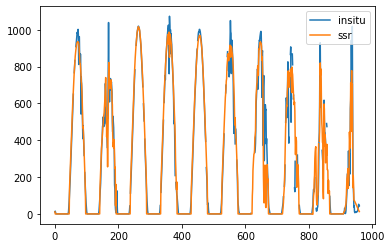

In [11]:
plt.plot(data['insitu']['data'],label='insitu')
plt.plot(data['ssr']['data'],label='ssr')
plt.legend()
plt.plot()

(0.9482229049991909, 4.7437643378519, 74.74819707699413, 0.272966629857219)

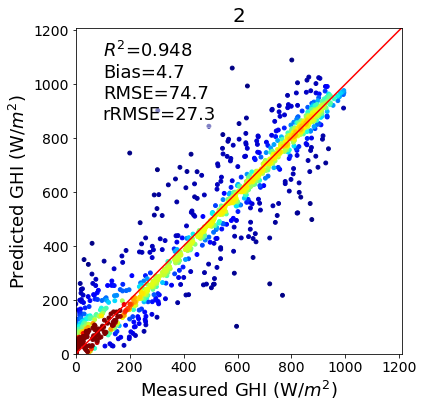

In [84]:
dt=pd.DataFrame()
dt['insitu']=data['insitu']['data']
dt['ssr']=data['ssr']['data']
dt=dt.dropna()
fig=plt.figure(figsize=(6,6))
DenseScatter_insitu(dt['insitu'].array,dt['ssr'].array,'2')

In [29]:
year = '2018'
tile_id = 'h15v03'
file_path = '{}/SolarSat_{}_{}_{}.hdf'

In [31]:
year = '2018'
tile_id = 'h15v03'
file_path = '{}/SolarSat_{}_{}_{}.hdf'
data = get_data(tile_id,24*100*4,24*102*4,'/gpfs/data1/lianggp/lir/solar_data/data/geonex_sat')

In [30]:
dt = pd.DataFrame()

# Loop through each tile and append data
for i in range(1, 20):
    print(i)
    data = get_data(tile_id=i, point_based=True, end_date=datetime.datetime(2018,12,31,23,45))
    temp_df = pd.DataFrame({
        'insitu': data['insitu']['data'],
        'ssr': data['ssr']['data']
    })
    temp_df['id']=i
    temp_df['time']=generate_time_all()[:-1]
    dt = dt.append(temp_df, ignore_index=True)

# Drop rows with missing values
# dt = dt.dropna()

# # Plotting
# fig = plt.figure(figsize=(6, 6))
# DenseScatter_insitu(dt['insitu'].values, dt['ssr'].values, '2')

# plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [31]:
dt

,insitu,ssr,id,time
0,0.000000,0.0,1,2018-01-01 00:00:00
1,0.000000,0.0,1,2018-01-01 00:15:00
2,0.000000,0.0,1,2018-01-01 00:30:00
3,0.000000,0.0,1,2018-01-01 00:45:00
4,0.000000,0.0,1,2018-01-01 01:00:00
...,...,...,...,...
665736,84.466667,0.0,19,2018-12-31 22:30:00
665737,127.400000,0.0,19,2018-12-31 22:45:00
665738,170.800000,187.8,19,2018-12-31 23:00:00
665739,214.800000,233.0,19,2018-12-31 23:15:00


In [32]:
dt.to_pickle('/gpfs/data1/lianggp/lir/solar_data/process_results/validation.pkl',protocol=4)

In [45]:
dt=pd.read_pickle('/gpfs/data1/lianggp/lir/solar_data/process_results/validation.pkl')
dt=dt.dropna()
dt=dt[dt.insitu>0]
# dt=dt[dt.ssr>0]
dt

,insitu,ssr,id,time
53,2.686667,0.0,1,2018-01-01 13:15:00
54,15.053333,0.0,1,2018-01-01 13:30:00
55,45.040000,0.0,1,2018-01-01 13:45:00
56,80.566667,0.0,1,2018-01-01 14:00:00
57,116.766667,0.0,1,2018-01-01 14:15:00
...,...,...,...,...
665736,84.466667,0.0,19,2018-12-31 22:30:00
665737,127.400000,0.0,19,2018-12-31 22:45:00
665738,170.800000,187.8,19,2018-12-31 23:00:00
665739,214.800000,233.0,19,2018-12-31 23:15:00


0.006666666666666667


(0.9042616745404457,
 3.369013914522806,
 94.25140832572015,
 0.2672903714096055,
 311545)

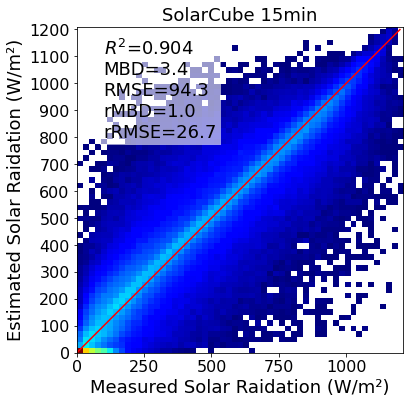

In [48]:
from matplotlib.colors import Normalize
def denseScatterHist1200(cp, tp, title, ax, show_ylabel=False):
    r2 = np.corrcoef(cp, tp)[1, 0] ** 2
    bias = np.mean(cp - tp)
    rmse = np.sqrt(np.mean((cp - tp) ** 2))
    nrmse = rmse / np.mean(tp)
    nbias = bias / np.mean(tp)
    n = cp.shape[0]
    
    hist, xbins, ybins = np.histogram2d(tp, cp, (60, 60))
    print(xbins.min())
    extent = [xbins.min(), xbins.max(), ybins.min(), ybins.max()]
    masked_hist = np.ma.masked_where(hist == 0, hist)
    norm = Normalize(vmin=masked_hist.min(), vmax=masked_hist.max()/10 )
    adjusted_hist = np.power(masked_hist, 0.3).T
    
    # im = ax.imshow(np.sqrt(np.ma.masked_where(hist == 0, hist).T), cmap='jet', origin='lower', extent=extent, norm=norm)
    im = ax.imshow(adjusted_hist, cmap='jet', origin='lower', extent=extent)
    ax.tick_params(labelsize=16)
    ax.set_xlabel('Measured Solar Raidation (W/m²)', fontsize=18)
    if show_ylabel:
        ax.set_ylabel('Estimated Solar Raidation (W/m²)', fontsize=18)
    ax.set_yticks(np.arange(0, 1201, 100))
    ax.plot(np.arange(1200), 'r')
    ax.axis([0, 1210, 0, 1210])
    ax.text(100, 800, '$R^2$={:.3f}\nMBD={:.1f}\nRMSE={:.1f}\nrMBD={:.1f}\nrRMSE={:.1f}'.format(r2, bias, rmse, nbias * 100,nrmse * 100), fontsize=18, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    ax.set_title(title, fontsize=18)
    
    return r2, bias, rmse, nrmse, n

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
denseScatterHist1200(dt['ssr'].values,dt['insitu'].values, 'SolarCube 15min', axs, show_ylabel=True)

2018-06-01 16:45:00
2018-06-01 17:00:00
2018-06-01 17:15:00
2018-06-01 17:30:00
2018-06-01 17:45:00
2018-06-01 18:00:00
2018-06-01 18:15:00
2018-06-01 18:30:00


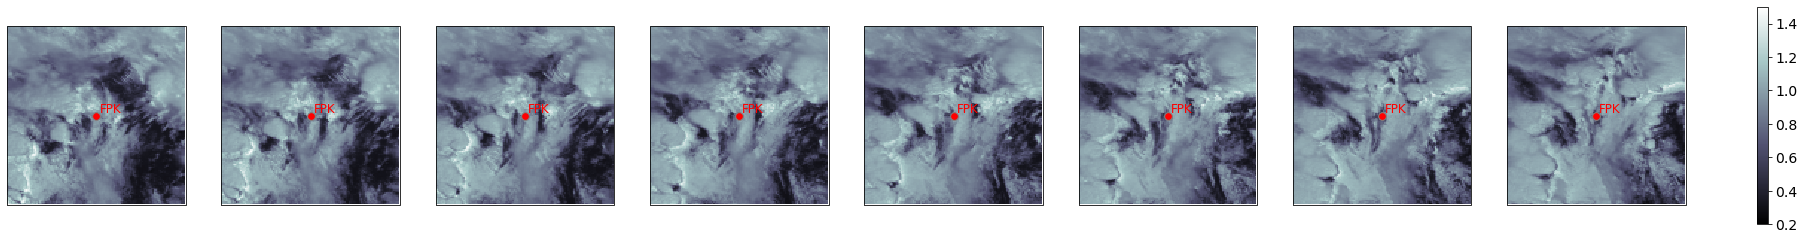

2018-06-01 16:45:00
2018-06-01 17:00:00
2018-06-01 17:15:00
2018-06-01 17:30:00
2018-06-01 17:45:00
2018-06-01 18:00:00
2018-06-01 18:15:00
2018-06-01 18:30:00


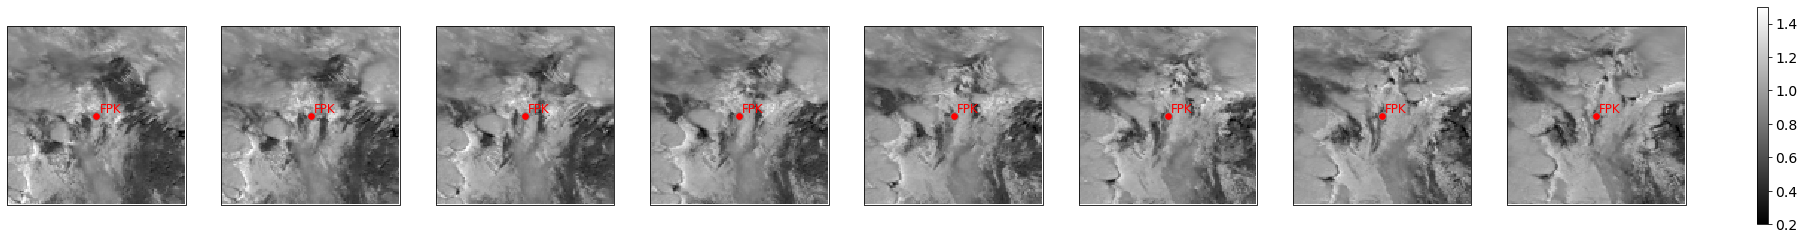

2018-06-01 16:45:00
2018-06-01 17:00:00
2018-06-01 17:15:00
2018-06-01 17:30:00
2018-06-01 17:45:00
2018-06-01 18:00:00
2018-06-01 18:15:00
2018-06-01 18:30:00


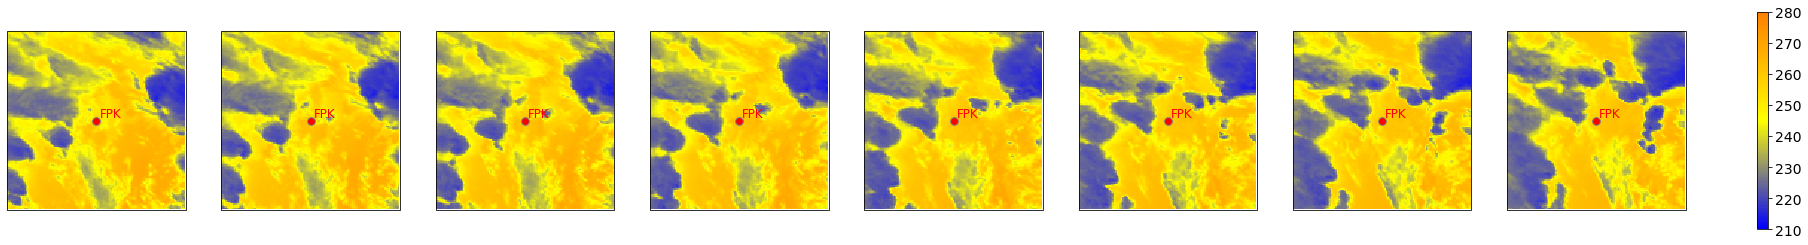

2018-06-01 16:45:00
2018-06-01 17:00:00
2018-06-01 17:15:00
2018-06-01 17:30:00
2018-06-01 17:45:00
2018-06-01 18:00:00
2018-06-01 18:15:00
2018-06-01 18:30:00


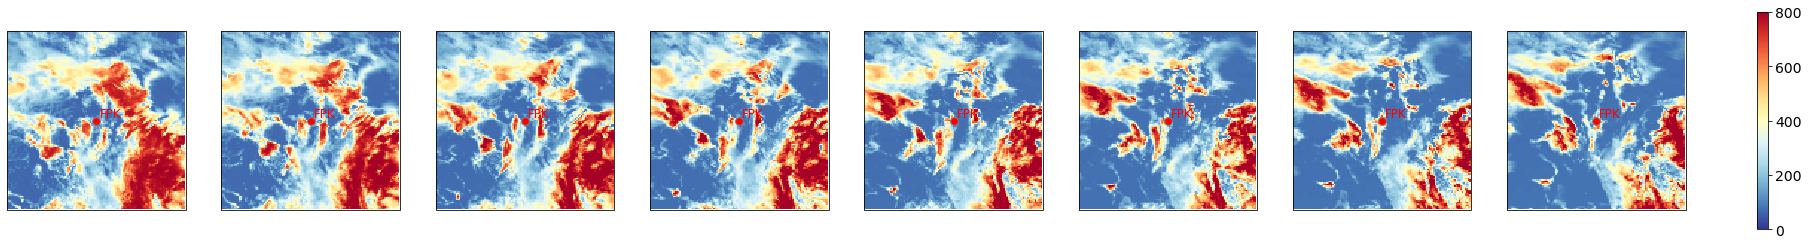

2018-06-01 16:45:00
2018-06-01 17:00:00
2018-06-01 17:15:00
2018-06-01 17:30:00
2018-06-01 17:45:00
2018-06-01 18:00:00
2018-06-01 18:15:00
2018-06-01 18:30:00


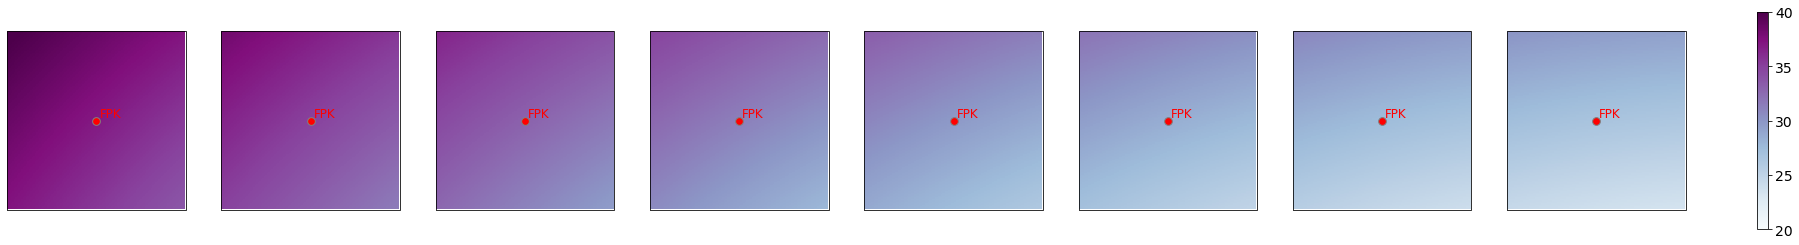

2018-06-01 16:45:00
2018-06-01 17:00:00
2018-06-01 17:15:00
2018-06-01 17:30:00
2018-06-01 17:45:00
2018-06-01 18:00:00
2018-06-01 18:15:00
2018-06-01 18:30:00


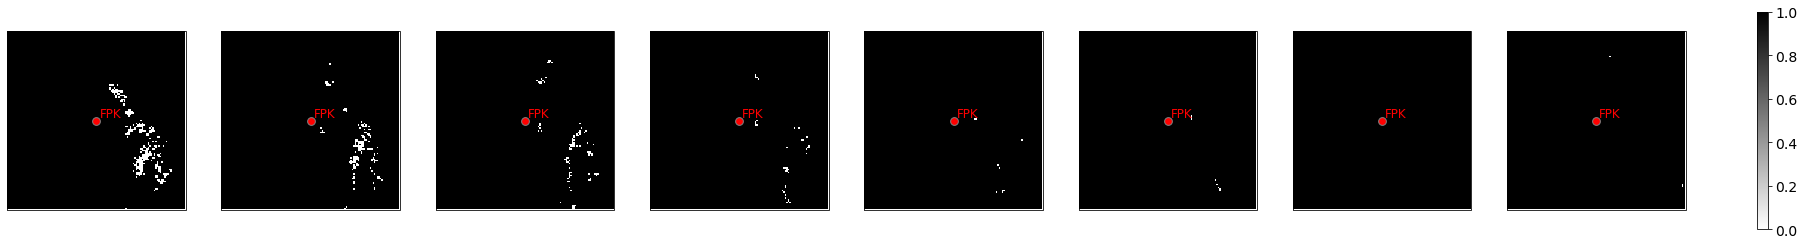

In [38]:
def make_images_continue(data, typ, out_location, idx):
    lona, lata = np.meshgrid(np.arange(data['meta']['lon_ulcnr'],data['meta']['lon_lrcnr'],0.05),np.arange(data['meta']['lat_ulcnr'],data['meta']['lat_lrcnr'],-0.05))

    fig, axs = plt.subplots(1, 8, figsize=(32, 4), subplot_kw={'projection': ccrs.PlateCarree()})


    # Now, we add the non-projected subplot manually
    # fig.add_subplot(1, len(TYPES), len(TYPES))  # Adding 'insitu' subplot without projection at the end


    if typ != 'insitu':
        if typ == 'vis047' :
            cmap = 'bone'
            vmin = 0.2
            vmax = 1.5
        if typ == 'vis086' :
            cmap = 'gray'
            vmin = 0.2
            vmax = 1.5
        if typ == 'ir133':
            cmap = ir_cmap
            vmin = 210
            vmax = 280
        if typ == 'ssr':
            cmap = 'RdYlBu_r'
            vmin = 0
            vmax = 800
        if typ == 'sza':
            cmap = 'BuPu'
            vmin = 20
            vmax = 40
        if typ == 'cm':
            cmap='gray_r'
            vmin = 0
            vmax = 1
            
    for i in range(8):
        axs[i].set_extent([data['meta']['lon_ulcnr'],data['meta']['lon_lrcnr'], data['meta']['lat_lrcnr'], data['meta']['lat_ulcnr']], ccrs.PlateCarree())

        im = axs[i].pcolormesh(lona, lata, data[typ]['data'][idx+i],transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax) #plot base map
        
        # Add country borders
        # axs[i].add_feature(states_provinces, edgecolor='gray')
        # axs[i].add_feature(cfeature.BORDERS)
        # axs[i].add_feature(cfeature.COASTLINE)

        #add point
        axs[i].scatter(data['meta']['lons'],data['meta']['lats'],c='red',s=60,label=data['meta']['name'],edgecolors='grey')
        axs[i].text(data['meta']['lons']+0.1,data['meta']['lats']+0.1,data['meta']['name'].upper(),c='red',size=12)
    # else:
    #     axs[i].plot(data[typ]['data'])
    #     axs[i].scatter(idx,data[typ]['data'][idx],c='red',s=60)
    
        print(data['meta']['utc_time'][idx+i])


    # axs[i].set_title(typ.upper(),fontsize=14)
    # fig.text(0.5, 0.08,  'Local Time: '+data['meta']['local_time'][idx].strftime('%Y-%m-%d %H:%M:%S'), ha='center', fontsize=12)
    
    cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.ax.tick_params(labelsize=14)  # Set tick label font size
    # cbar.set_label('Value')
    
    plt.savefig(out_location+f'/view_sample_{typ}.png', dpi=400)
    plt.show()
    plt.close(fig)

 
    # fig, ax = plt.subplots()
    # plt.plot(data[typ]['data'], c='black')
    # plt.scatter(idx,data[typ]['data'][idx],c='red',s=60)
    # # plt.savefig(out_location+f'/view_sample_insitu_{idx}.png', dpi=400)
    # plt.show()
    # plt.close(fig)

save_location = '/gpfs/data1/lianggp/lir/solar_data/plot_results'
for typ in TYPES[:-1]:
    make_images_continue(data,typ,save_location,67+24*4)

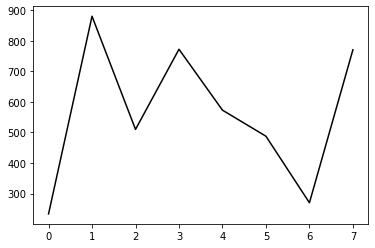

In [17]:
fig, ax = plt.subplots()
plt.plot(data['insitu']['data'][70+24*4:70+24*4+8], c='black')
# plt.scatter(idx,data[typ]['data'][idx],c='red',s=60)
# plt.savefig(out_location+f'/view_sample_insitu_{idx}.png', dpi=400)
plt.show()
plt.close(fig)

In [ ]:
lona=np.arange(-90,-84,0.01)
lata=np.arange(42,36,-0.01)
lona, lata = np.meshgrid(np.arange(-90,-84,0.01),np.arange(42,36,-0.01))

In [ ]:
for i in range(2*24*4):
    plt.imshow(data['vis047']['data'][i])
    plt.title(i)
    plt.show()

In [10]:
def make_images(data, out_location, idx):
    lona, lata = np.meshgrid(np.arange(data['meta']['lon_ulcnr'],data['meta']['lon_lrcnr'],0.05),np.arange(data['meta']['lat_ulcnr'],data['meta']['lat_lrcnr'],-0.05))

#     fig, axs = plt.subplots(1, len(TYPES), figsize=(20, 4),
#                             subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Create subplots, initially with the projection for all of them
    fig, axs = plt.subplots(1, len(TYPES), figsize=(20, 4), subplot_kw={'projection': ccrs.PlateCarree()})

    # Make sure axs is iterable
    if len(TYPES)-1 == 1:
        axs = [axs]

    # Now, we add the non-projected subplot manually
    # fig.add_subplot(1, len(TYPES), len(TYPES))  # Adding 'insitu' subplot without projection at the end

    # We get the new axs array including all subplots
    axs = [fig.axes[i] for i in range(len(TYPES))]
    axs[len(TYPES)-1] = fig.axes[-1]

    for i,typ in enumerate(TYPES):
        print(typ)
        if typ != 'insitu':
            if typ == 'vis047' :
                cmap = 'bone'
                vmin = 0.2
                vmax = 1.5
            if typ == 'vis086' :
                cmap = 'gray'
                vmin = 0.2
                vmax = 1.5
            if typ == 'ir133':
                cmap = ir_cmap
                vmin = 210
                vmax = 280
            if typ == 'ssr':
                cmap = 'RdYlBu_r'
                vmin = 0
                vmax = 800
            if typ == 'sza':
                cmap = 'BuPu'
                vmin = 20
                vmax = 40
            axs[i].set_extent([data['meta']['lon_ulcnr'],data['meta']['lon_lrcnr'], data['meta']['lat_lrcnr'], data['meta']['lat_ulcnr']], ccrs.PlateCarree())

            axs[i].pcolormesh(lona, lata, data[typ]['data'][idx],transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax) #plot base map
            
            # Add country borders
            # axs[i].add_feature(states_provinces, edgecolor='gray')
            # axs[i].add_feature(cfeature.BORDERS)
            # axs[i].add_feature(cfeature.COASTLINE)

            #add point
            axs[i].scatter(data['meta']['lons'],data['meta']['lats'],c='red',s=60,label=data['meta']['name'],edgecolors='grey')
            axs[i].text(data['meta']['lons']+0.1,data['meta']['lats']+0.1,data['meta']['name'].upper(),c='red',size=12)
        # else:
        #     axs[i].plot(data[typ]['data'])
        #     axs[i].scatter(idx,data[typ]['data'][idx],c='red',s=60)


        axs[i].set_title(typ.upper(),fontsize=14)
    fig.text(0.5, 0.08,  'Local Time: '+data['meta']['local_time'][idx].strftime('%Y-%m-%d %H:%M:%S'), ha='center', fontsize=12)
    # plt.savefig(out_location+f'/view_sample_{idx}.png', dpi=400)
    plt.show()
    plt.close(fig)

 
    fig, ax = plt.subplots()
    plt.plot(data[typ]['data'], c='black')
    plt.scatter(idx,data[typ]['data'][idx],c='red',s=60)
    # plt.savefig(out_location+f'/view_sample_insitu_{idx}.png', dpi=400)
    plt.show()
    plt.close(fig)




In [36]:
year = '2018'
tile_id = 2
file_path = '{}/SolarSat_{}_{}_{}.hdf'
start_date = datetime.datetime(2018, 5, 31)
end_date = datetime.datetime(2018, 6, 3)
data = get_data(tile_id=tile_id,start_date=start_date,end_date=end_date,point_based=False)

In [9]:
make_images_continue(data,'',70+24*4)

TypeError: make_images_continue() missing 1 required positional argument: 'idx'

vis047
vis086
ir133
ssr
sza
insitu


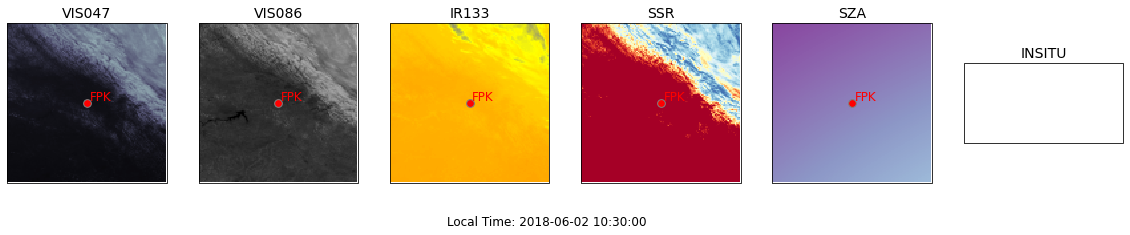

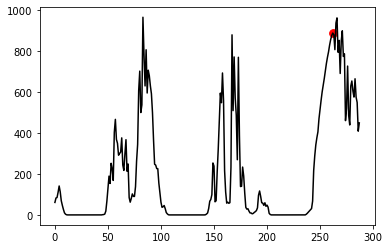

In [31]:
save_location = '/gpfs/data1/lianggp/lir/solar_data/plot_results'
make_images(data, save_location,70+24*4+24*4)

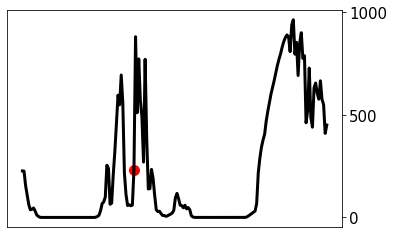

In [135]:
year = '2018'
tile_id = 2
file_path = '{}/SolarSat_{}_{}_{}.hdf'
start_date = datetime.datetime(2018, 6, 1)
end_date = datetime.datetime(2018, 6, 3)
data = get_data(tile_id=tile_id,start_date=start_date,end_date=end_date,point_based=False)


fig, ax = plt.subplots(figsize=(6, 4))
typ = 'insitu'
idx=70
# Plot the data
ax.plot(data[typ]['data'], c='black', linewidth=3)
ax.scatter(idx, data[typ]['data'][idx], c='red', s=100)
# Hide the x-axis
ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
ax.yaxis.tick_right()
ax.set_yticks([0,500,1000])
ax.set_yticklabels(['0','500','1000'], size=15)
# Set y-tick direction to 'in'
# ax.tick_params(axis='y', direction='in', pad=-40)

# Save the plot
out_location = './'  # Change this to your desired output location
idx = 1  # Example index, change as needed
# plt.savefig(out_location+f'/view_sample_insitu_{idx}.png', dpi=400)


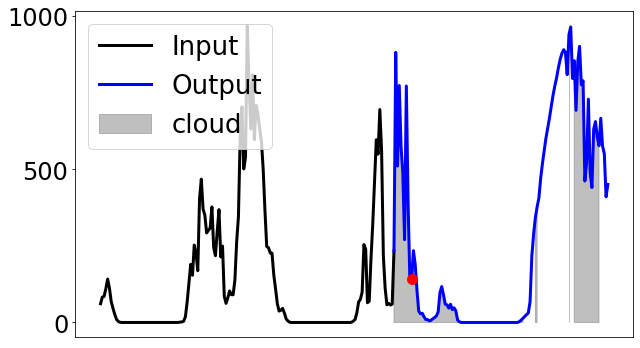

In [70]:
from matplotlib.patches import Patch

year = '2018'
tile_id = 2
file_path = '{}/SolarSat_{}_{}_{}.hdf'
start_date = datetime.datetime(2018, 5,31)
end_date = datetime.datetime(2018, 6, 3)
data = get_data(tile_id=tile_id,start_date=start_date,end_date=end_date,point_based=False)

df_cloud = pd.read_csv('/gpfs/data1/lianggp/lir/solar_data/data/geonex_sat/solarsat_cloudmask.csv')
start, end = return_index(start_date, end_date)
cc=df_cloud[str(tile_id)][start:end].to_numpy()

fig, ax = plt.subplots(figsize=(10, 6))
typ = 'insitu'
idx=70+24*4
# Plot the data
ax.fill_between(
    range(idx, len(data[typ]['data'])), 
    data[typ]['data'][idx:], 
    where=cc[idx:] == 1, 
    color='gray', 
    alpha=0.5
)

# Plot the data up to idx in black
line1, =ax.plot(range(idx+1), data[typ]['data'][:idx+1], c='black', linewidth=3,label='Input')
# Plot the data after idx in blue
line2,=ax.plot(range(idx, len(data[typ]['data'])), data[typ]['data'][idx:], c='blue', linewidth=3, label='Output')

ax.scatter(idx+10, data[typ]['data'][idx+10], c='red', s=100, zorder=5)
# Hide the x-axis
ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# ax.yaxis.tick_right()
ax.set_yticks([0,500,1000])
ax.set_yticklabels(['0','500','1000'], size=24)

# Create custom legend entry
cloud_patch = Patch(color='gray', alpha=0.5, label='cloud')

# Add legend
ax.legend(handles=[line1, line2, cloud_patch], loc='upper left', fontsize=26)
# ax.legend(loc='upper left', fontsize=15)
plt.savefig(f'/gpfs/data1/lianggp/lir/solar_data/plot_results/point3.png', dpi=400)

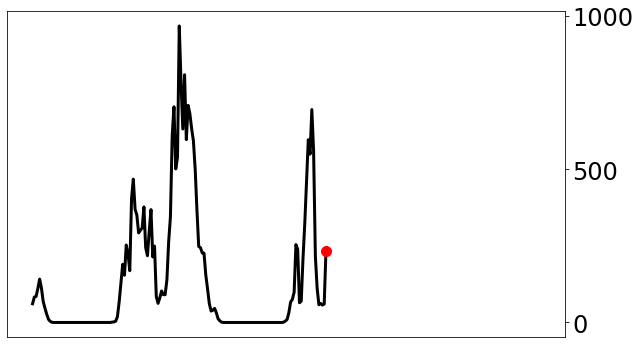

In [72]:
from matplotlib.patches import Patch

year = '2018'
tile_id = 2
file_path = '{}/SolarSat_{}_{}_{}.hdf'
start_date = datetime.datetime(2018, 5,31)
end_date = datetime.datetime(2018, 6, 3)
data = get_data(tile_id=tile_id,start_date=start_date,end_date=end_date,point_based=False)

df_cloud = pd.read_csv('/gpfs/data1/lianggp/lir/solar_data/data/geonex_sat/solarsat_cloudmask.csv')
start, end = return_index(start_date, end_date)
cc=df_cloud[str(tile_id)][start:end].to_numpy()

fig, ax = plt.subplots(figsize=(10, 6))
typ = 'insitu'
idx=70+24*4
# Plot the data
# ax.fill_between(
#     range(idx, len(data[typ]['data'])), 
#     data[typ]['data'][idx:], 
#     where=cc[idx:] == 1, 
#     color='gray', 
#     alpha=0.5
# )

# Plot the data up to idx in black
line1, =ax.plot(range(idx+1), data[typ]['data'][:idx+1], c='black', linewidth=3,label='Input')
# Plot the data after idx in blue
line2,=ax.plot(range(idx, len(data[typ]['data'])), data[typ]['data'][idx:], c='white', linewidth=3, label='Output')

ax.scatter(idx, data[typ]['data'][idx], c='red', s=100, zorder=5)
# Hide the x-axis
ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
ax.yaxis.tick_right()
ax.set_yticks([0,500,1000])
ax.set_yticklabels(['0','500','1000'], size=24)

# Create custom legend entry
cloud_patch = Patch(color='gray', alpha=0.5, label='cloud')

# Add legend
# ax.legend(handles=[line1, line2, cloud_patch], loc='upper left', fontsize=26)
# ax.legend(loc='upper left', fontsize=15)
plt.savefig(f'/gpfs/data1/lianggp/lir/solar_data/plot_results/point2.png', dpi=400)

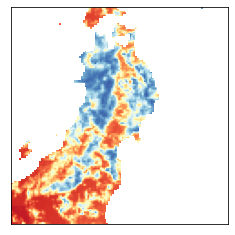

In [55]:
year = '2018'
tile_id = 19
file_path = '{}/SolarSat_{}_{}_{}.hdf'
start_date = datetime.datetime(2018, 5,31)
end_date = datetime.datetime(2018, 6, 3)
data = get_data(tile_id=tile_id,start_date=start_date,end_date=end_date,point_based=False)

idx=12 +24*4 +12
typ='ssr'
if typ == 'ssr':
    cmap = 'RdYlBu_r'
    vmin = 0
    vmax = 800
if typ == 'sza':
    cmap = 'BuPu'
    vmin = 20
    vmax = 40
    
    
fig, ax = plt.subplots()  # Create a figure and an axes
# Plot the base map using imshow on the axes
ax.imshow(data[typ]['data'][idx], cmap=cmap, vmin=vmin, vmax=vmax)
# Hide the x-axis and y-axis
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig(f'/gpfs/data1/lianggp/lir/solar_data/plot_results/{typ}_{idx}.png', dpi=400)

In [62]:
np.isnan(data[typ]['data'][idx])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

(288, 120, 120)


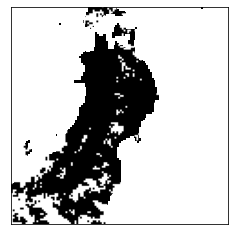

In [66]:
import h5py
arrays_list = []
id=19
start_date = datetime.datetime(2018, 5, 31)
end_date = datetime.datetime(2018, 6, 3)
start, end = return_index(start_date, end_date)
file_name_sza= '{}/SolarSat_{}_{}_{}.hdf'.format(DEFAULT_DATA_HOME, 2018, id, 'cm')
with h5py.File(file_name_sza,'r') as hf:  
    fillvalue = hf['cm'].attrs.get('fillvalue', None)
    cloud_array = hf['cm'][start:end, :,:]  
    nan_value = fillvalue 
print(cloud_array.shape)

idx=12 +24*4 +12
fig, ax = plt.subplots()  # Create a figure and an axes
# Plot the base map using imshow on the axes
cloud_array = cloud_array.astype(float)

# Assign np.nan to the positions where data[typ]['data'][idx] is NaN
cloud_array[idx][np.isnan(data[typ]['data'][idx])] = np.nan

ax.imshow(cloud_array[idx], cmap='gray_r', vmin=0, vmax=1)
# Hide the x-axis and y-axis
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig(f'/gpfs/data1/lianggp/lir/solar_data/plot_results/{typ}_cm.png', dpi=400)

In [25]:
cloud_array[idx].max()

1

In [106]:
out_location+f'/view_sample_insitu_{idx}.png'

'.//view_sample_insitu_166.png'

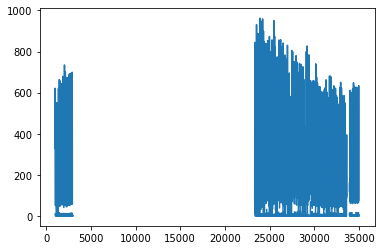

In [49]:
a = genertate_insitu(14)
plt.plot(a)

In [ ]:
data['meta']['local_time']

DatetimeIndex(['2018-04-11 00:00:00', '2018-04-11 00:15:00',
               '2018-04-11 00:30:00', '2018-04-11 00:45:00',
               '2018-04-11 01:00:00', '2018-04-11 01:15:00',
               '2018-04-11 01:30:00', '2018-04-11 01:45:00',
               '2018-04-11 02:00:00', '2018-04-11 02:15:00',
               ...
               '2018-04-12 21:30:00', '2018-04-12 21:45:00',
               '2018-04-12 22:00:00', '2018-04-12 22:15:00',
               '2018-04-12 22:30:00', '2018-04-12 22:45:00',
               '2018-04-12 23:00:00', '2018-04-12 23:15:00',
               '2018-04-12 23:30:00', '2018-04-12 23:45:00'],
              dtype='datetime64[ns]', length=192, freq='15T')

In [ ]:
def make_images(data, out_location, idx):
    lona, lata = np.meshgrid(np.arange(data['meta']['lon_ulcnr'],data['meta']['lon_lrcnr'],0.01),np.arange(data['meta']['lat_ulcnr'],data['meta']['lat_lrcnr'],-0.01))

    fig, axs = plt.subplots(1, len(TYPES), figsize=(24, 4))

    for i, typ in enumerate(TYPES):
        if typ != 'insitu':
            # Create subplot with a geographic projection
            ax = fig.add_subplot(1, len(TYPES), i + 1, projection=ccrs.PlateCarree())
            ax.set_extent([data['meta']['lon_ulcnr'], data['meta']['lon_lrcnr'],
                           data['meta']['lat_lrcnr'], data['meta']['lat_ulcnr']], ccrs.PlateCarree())
            ax.add_feature(states_provinces, edgecolor='gray')
            ax.pcolormesh(lona, lata, data[typ]['data'][idx],transform=ccrs.PlateCarree())
            ax.scatter(data['meta']['lons'], data['meta']['lats'], c='red', s=60, label=data['meta']['name'], edgecolors='grey')
            ax.text(data['meta']['lons']+0.1, data['meta']['lats']+0.1, data['meta']['name'].upper(), color='red', size=12)
            
            for spine in ax.spines.values():
                spine.set_visible(False)
            ax.outline_patch.set_visible(False)
            ax.background_patch.set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        else:
            # Create a regular plot
            ax = fig.add_subplot(1, len(TYPES), i + 1)
            ax.plot(data[typ]['data'])
        ax.set_title(typ.upper(),fontsize=14)

    plt.show()

In [ ]:
data['meta']['local_time'][50]

Timestamp('2018-04-11 12:30:00', freq='15T')

In [ ]:
def make_basemap(s,ax=None,res='c'):
    if ax:
        return Basemap(llcrnrlat=s.llcrnrlat, llcrnrlon=s.llcrnrlon,
                    urcrnrlat=s.urcrnrlat,urcrnrlon=s.urcrnrlon,
                    width=s.width_m, height=s.height_m,
                    lat_0=38, lon_0=-98,
                    projection='laea', 
                    resolution=res,
                    ax=ax)
    else:
        return Basemap(llcrnrlat=s.llcrnrlat, llcrnrlon=s.llcrnrlon,
                    urcrnrlat=s.urcrnrlat,urcrnrlon=s.urcrnrlon,
                    width=s.width_m, height=s.height_m,
                    lat_0=38, lon_0=-98,
                    projection='laea', 
                    resolution=res)


In [ ]:
def make_images2(data, out_location, id,  res='c'):
    
    # initialize maps 
    #fig = plt.figure(set_frameon=False)
    fig,ax = plt.subplots(1,len(TYPES),figsize=(20,4))
    
    #fig.set_visible(False)
    maps = []
    ims  = []
    for i,typ in enumerate(TYPES):
        if typ not in data:
            maps.append(None)
            ims.append(None)
            continue


        if typ != 'insitu':
            n_img = data[typ]['data'].shape[2]
            maps.append( make_basemap(data[typ]['meta'],ax=ax[i],res=res) )
            c = 'r' if typ=='vis' else 'k'
            cmap,norm,vmin,vmax=get_cmap(typ)
            maps[-1].drawstates(color=c)
            maps[-1].drawcoastlines(color=c)
            ims.append(  maps[-1].imshow(data[typ]['data'][:,:,0],cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) )
            time = get_time(data[typ]['meta'],0)
            ax[i].set_xlabel(time)
            ax[i].set_title(get_title(typ))
        else:
            # create first lght frame
            lght_time0 = datetime.datetime.strptime( data['lght']['meta'].time_utc, '%Y-%m-%d %H:%M:%S')
            lght_times = np.array([lght_time0 + datetime.timedelta(seconds=int(s)) for s in data['lght']['data'][:,0]])
            maps.append( make_basemap(data['lght']['meta'],ax=ax[i],res=res) )
            maps[-1].drawstates(color=c)
            maps[-1].drawcoastlines(color=c)
            t0 = lght_time0+datetime.timedelta(minutes=FRAME_TIMES[0])
            t1 = lght_time0+datetime.timedelta(minutes=FRAME_TIMES[1])
            make_lght_frames(data,maps[-1],t0,t1,lght_times=lght_times)
            ax[-1].set_xlabel(time)
            ax[-1].set_title('GOES-16 GLM Lightning Flashes')
        update_progress(np.round( 100 * 1/len(FRAME_TIMES) ) / 100)


    fig.savefig(f'{out_location}/{id}_000.png')
    
    n_img = 49 # Think of way to get this from data
    
    for t in range(1,n_img):
        for i,typ in enumerate(TYPES):
            if typ not in data:
                continue
            if typ != 'lght':
                ims[i].set_array(data[typ]['data'][:,:,t])
                time = get_time(data[typ]['meta'],t)
                ax[i].set_xlabel(time)
            elif typ=='lght':
                #time = get_time(data[typ]['meta'],t)
                time = lght_time0 + datetime.timedelta(minutes=(FRAME_TIMES[t]+2.5))
                t0 = lght_time0+datetime.timedelta(minutes=FRAME_TIMES[t])
                t1 = lght_time0+datetime.timedelta(minutes=FRAME_TIMES[t+1])
                make_lght_frames(data,maps[i],t0,t1,lght_times=lght_times)
                ax[-1].set_xlabel(time)
        fig.savefig(f'{out_location}/{id}_%.3d.png' % t)
        update_progress(np.round( 100 * t/len(FRAME_TIMES) ) / 100)

